In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

## 0. Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

# Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### a) Changing mutation rate

In [6]:
n_NS = len(genome)
n_p = 5000
n_r = 15
ep_wt = -5
er_wt = -15

In [7]:
mutrate = np.arange(0.03, 0.3, 0.01)
signal_rnap = []
signal_rep = []

for mr in mutrate:
    rnap = []
    rep = []
    for i in range(100):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                mutrate=float(mr))

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    signal_rnap.append((np.mean(rnap), np.std(rnap)))
    signal_rep.append((np.mean(rep), np.std(rep)))

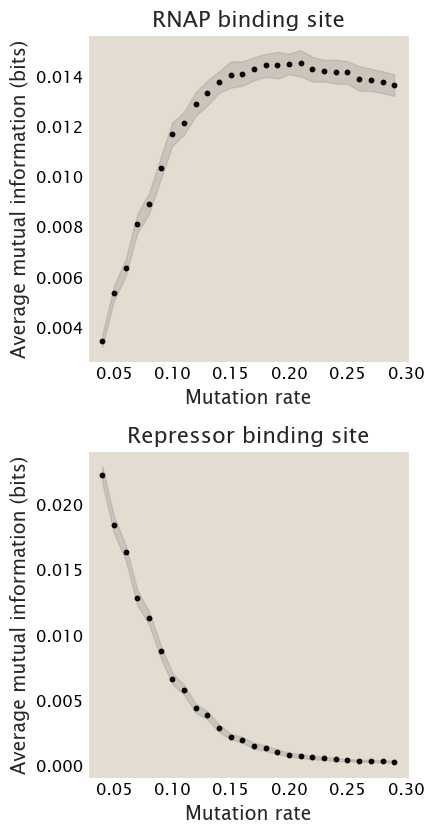

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(4.5, 8.5))
ax1, ax2 = axes
ax1.fill_between(mutrate[1:],
                 np.asarray(signal_rnap[1:])[:, 0] - np.asarray(signal_rnap[1:])[:, 1],
                 np.asarray(signal_rnap[1:])[:, 0] + np.asarray(signal_rnap[1:])[:, 1],
                 color='grey', alpha=0.25) 
ax1.scatter(mutrate[1:], np.asarray(signal_rnap)[1:, 0], color='k', s=10)
ax1.set_xlabel('Mutation rate', fontsize=14)
ax1.set_ylabel('Average mutual information (bits)', fontsize=14)
ax1.set_title('RNAP binding site', fontsize=16)

ax2.fill_between(mutrate[1:],
                 np.asarray(signal_rep[1:])[:, 0] - np.asarray(signal_rep[1:])[:, 1],
                 np.asarray(signal_rep[1:])[:, 0] + np.asarray(signal_rep[1:])[:, 1],
                 color='grey', alpha=0.25) 
ax2.scatter(mutrate[1:], np.asarray(signal_rep[1:])[:, 0], color='k', s=10)
ax2.set_xlabel('Mutation rate', fontsize=14)
ax2.set_ylabel('Average mutual information (bits)', fontsize=14)
ax2.set_title('Repressor binding site', fontsize=16)

plt.tight_layout()
plt.savefig('../plots/fig4/mutation_rate.pdf', dpi=300)

### b) Example footprints

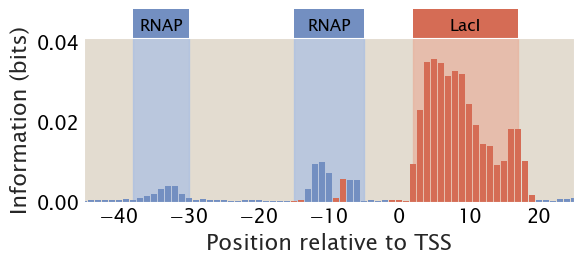

In [9]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.04)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/figS3/weak_rnap.pdf',                               
                               legend_xcoord=1.05)
# outfile='../../manuscript/figures/plots/fig4/mutation_rate_fp1.png',

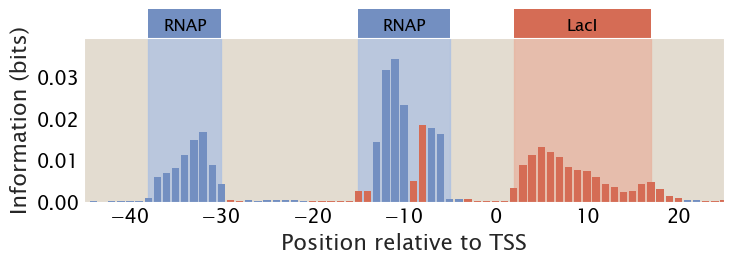

In [10]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.1)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=7.5,
                               outfile='../plots/fig4/mutation_rate_fp2.pdf',
                               legend_xcoord=1.05)

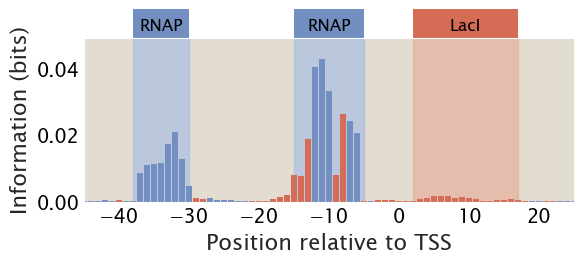

In [11]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.2)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/figS3/strong_repressor_emat.pdf',
                               legend_xcoord=1.05)

#outfile='../../manuscript/figures/plots/fig4/mutation_rate_fp3.png',

### c) Mutational bias

In [12]:
n_NS = len(genome)
n_p = 4600
n_r = 15
ep_wt = -5
er_wt = -15

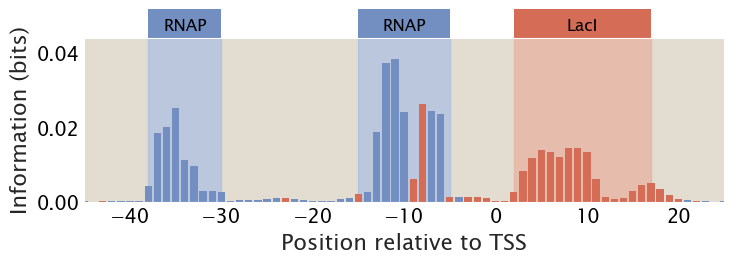

In [13]:
# allowing swappings between A and G, and C and T
allowed_alph = np.array([[False, False, True, False],
                         [False, False, False, True],
                         [True, False, False, False],
                         [False, True, False, False]])

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        allowed_alph=allowed_alph)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=7.5,
                               outfile='../plots/fig4/mutation_bias_fp1.pdf',
                               legend_xcoord=1.05)

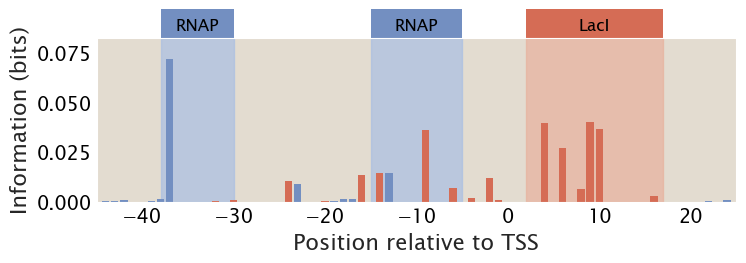

In [14]:
# only allowing C to T and G to A changes, without smoothing
allowed_alph = np.array([[False, False, False, False],
                         [False, False, False, True],
                         [True, False, False, False],
                         [False, False, False, False]])

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        allowed_alph=allowed_alph, mutrate=0.1,
                        biased=True)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=7.5,
                               outfile='../plots/fig4/mutation_bias_fp2.pdf',
                               legend_xcoord=1.05, smoothed=False)